In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import config
from PIL import Image
import os
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.utils import to_categorical
#Use Python 3.10 since tensorflow does not support Python newer than that

# 1. Read Data


In [4]:
#Create an config.py file to store your label_path and image_folder_path. So that we do not have to upload the dataset up to github, keep the dataset to our local
label_path = config.LABEL_PATH
image_folder_path = config.IMAGE_FOLDER_PATH


In [5]:
label_df = pd.read_csv(label_path)
label_df.shape

(9896, 6)

In [6]:
label_df

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


## 2. EDA


### 2.1 Image Format check

In [9]:
# Define common image extensions
image_extensions ='.png'

all_files = [f for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]
total_files = len(all_files)

# Identify non-image files
non_image_files = [f for f in all_files if not f.lower().endswith(image_extensions)]

# Output results
print(f"Total files in folder: {total_files}")
print(f"Non-image files: {len(non_image_files)}")

if non_image_files:
    print("Files that are not images:")
    for file in non_image_files:
        print(f" - {file}")
else:
    print("All files are images ending with .png.")

Total files in folder: 20280
Non-image files: 0
All files are images ending with .png.


In [10]:
def find_wrong_format_images(label_df, image_folder):
    """
    Identifies and returns a list of image names from a DataFrame that are
    not 27x27 pixels or are not in RGB color space according to the Assignment Detail.
    """
    wrong_format_images = []

    for index, row in label_df.iterrows():
        image_name = row['ImageName']
        image_path = os.path.join(image_folder, image_name)
        is_27x27 = False
        is_rgb = False

        try:
            img = Image.open(image_path)
            width, height = img.size
            if width == 27 and height == 27:
                is_27x27 = True

            if img.mode == 'RGB':
                is_rgb = True

            img.close()

            if not is_27x27 or not is_rgb:
                wrong_format_images.append(image_name)

        except FileNotFoundError:
            print(f"Warning: Image not found at {image_path}")
            wrong_format_images.append(image_name) # Consider it wrong_format if not found
        except Exception as e:
            print(f"Warning: Error processing {image_path}: {e}")
            wrong_format_images.append(image_name) # Consider it wrong_format if processing fails

    return wrong_format_images


wrong_format_image_list = find_wrong_format_images(label_df.copy(), image_folder_path)

if wrong_format_image_list:
    print("List of image names that are NOT 27x27 or NOT RGB:")
    for img_name in wrong_format_image_list:
        print(f"- {img_name}")
    print(f"\nTotal number of wrong format images found: {len(wrong_format_image_list)}")
else:
    print("All images in the list are 27x27 and RGB.")

All images in the list are 27x27 and RGB.


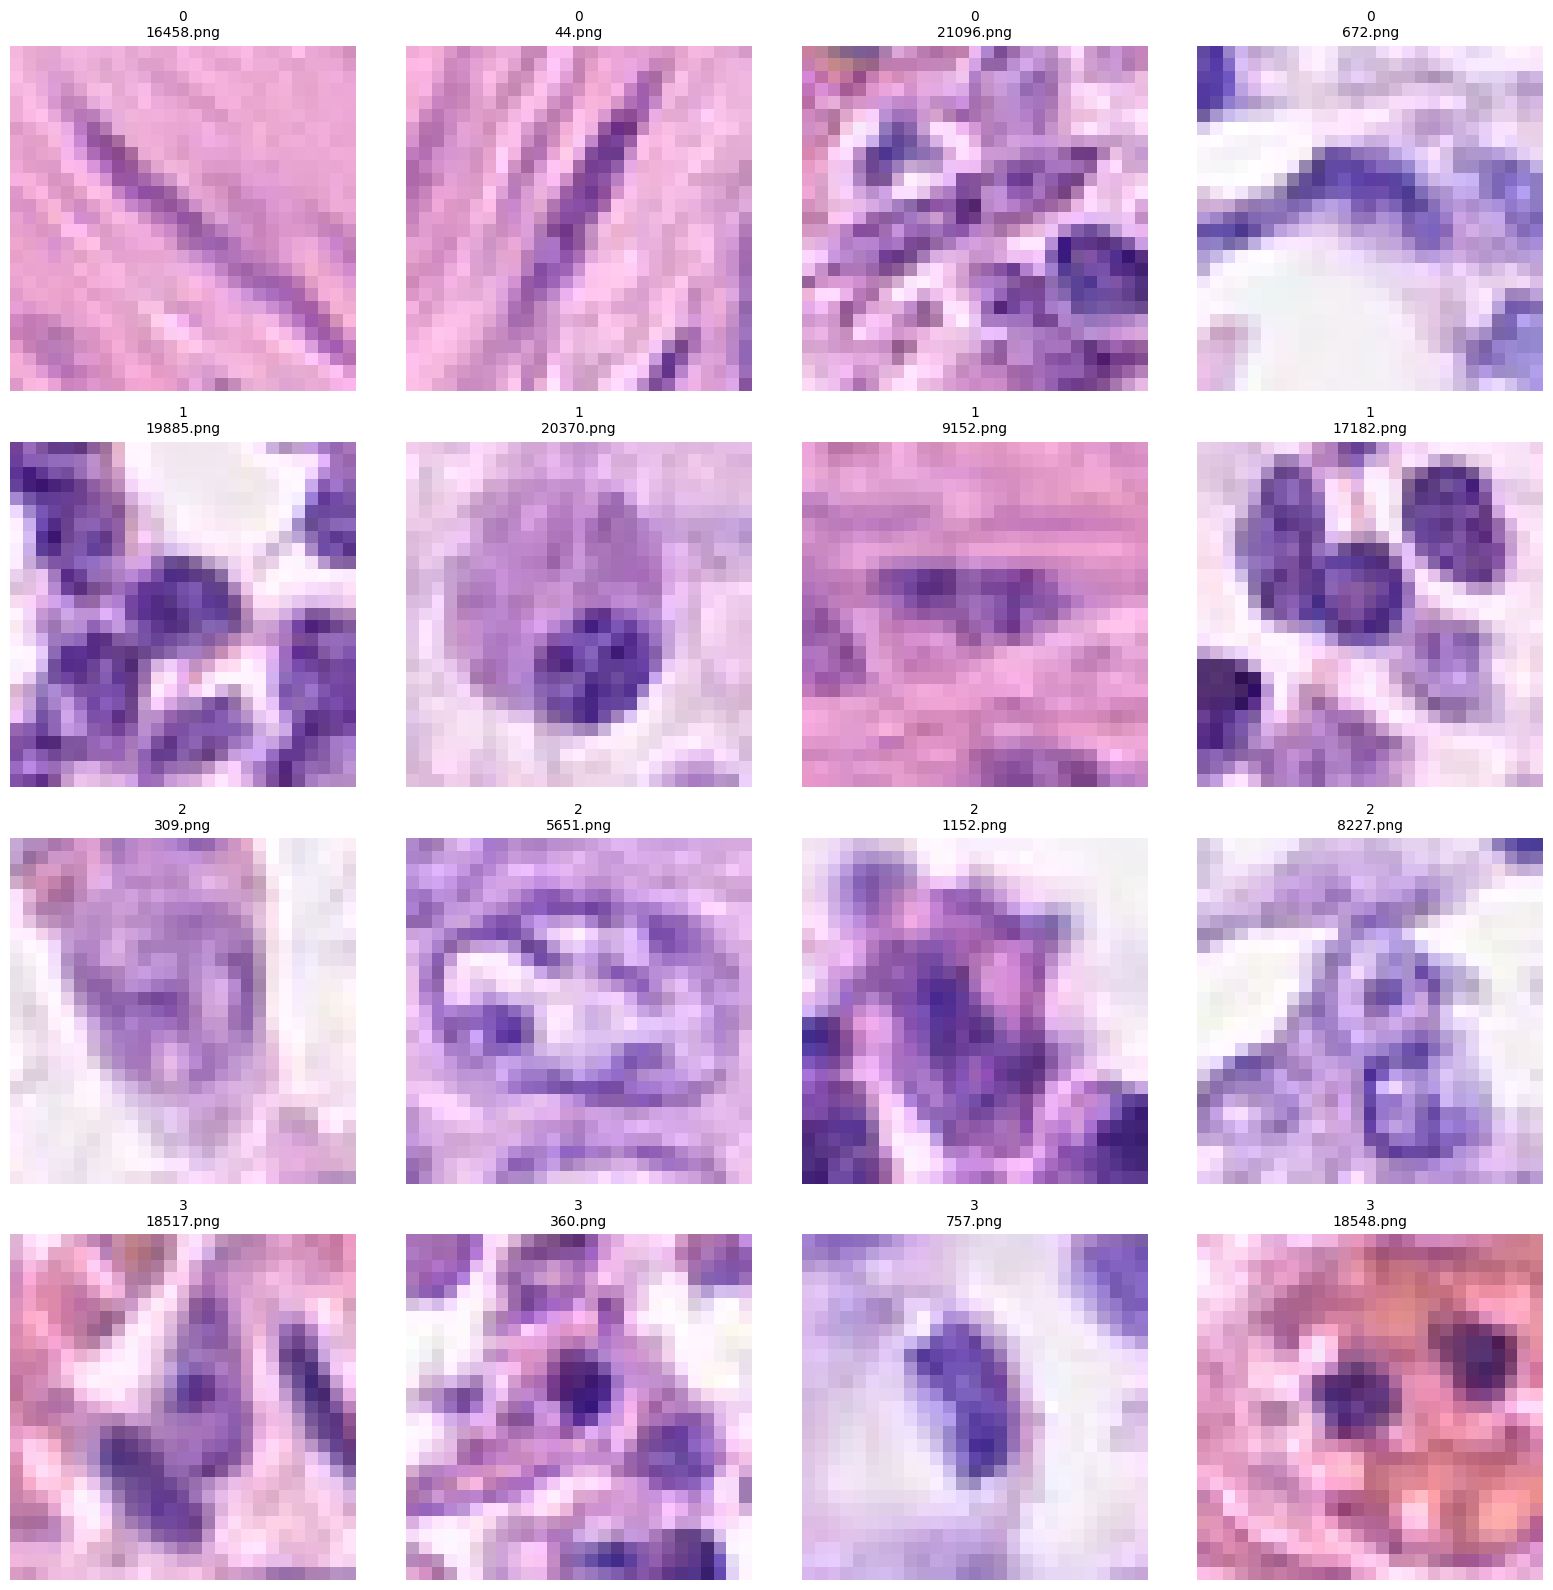

In [11]:
plt.figure(figsize=(16, 16))

img_index = 1

for i in range(0,4):
    # Randomly select 4 images for each cell type
    sample_rows = label_df[label_df["cellType"] == i].sample(n=4, random_state=42)

    for _, row in sample_rows.iterrows():
        img_path = os.path.join(image_folder_path, row["ImageName"])
        img = Image.open(img_path)

        plt.subplot(4, 4, img_index)
        plt.imshow(img, interpolation='nearest')
        plt.title(f'{i}\n{row["ImageName"]}', fontsize=10)
        plt.axis('off')

        img_index += 1

plt.tight_layout()
plt.show()

### 2.2 Distribution check and class imbalance

In [13]:
print(label_df.isna().sum())

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


In [14]:
for col in ["cellType", "isCancerous"]:
    print(label_df[col].value_counts())

cellType
2    4079
1    2543
0    1888
3    1386
Name: count, dtype: int64
isCancerous
0    5817
1    4079
Name: count, dtype: int64


In [15]:
contingency_table = pd.crosstab(label_df['cellType'], label_df['isCancerous'], 
                                rownames=['Cell Type'], colnames=['Is Cancerous'])

print("\nContingency Table (cellType vs isCancerous):")
print(contingency_table)


Contingency Table (cellType vs isCancerous):
Is Cancerous     0     1
Cell Type               
0             1888     0
1             2543     0
2                0  4079
3             1386     0


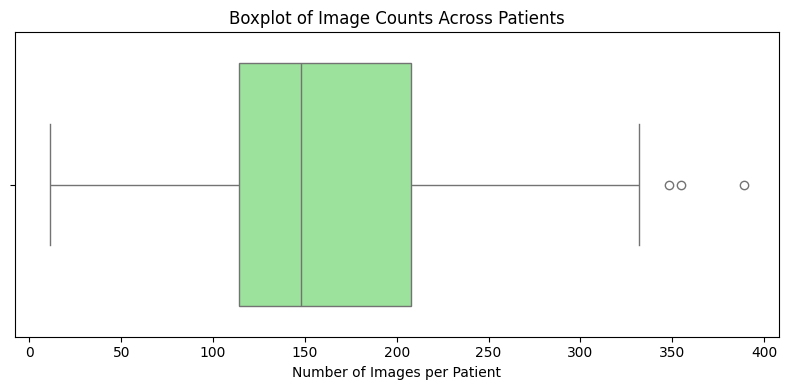

In [16]:
image_dis = label_df['patientID'].value_counts().sort_index()

#Plot to see the distribution and variance of image counts per patient
plt.figure(figsize=(8, 4))
sns.boxplot(x=image_dis, color="lightgreen")
plt.xlabel("Number of Images per Patient")
plt.title("Boxplot of Image Counts Across Patients")
plt.tight_layout()
plt.show()

In [17]:
label_df.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


**Finding and Justification from EDA**
- ALL images has the same format of 27x27 pixels, RGB color space, .png image file type. So we do not need any futher processing of the images.
- We randomly take 4 images of each cell type to manually visualize them and manual test if there might be any anomaly images. 16 images that we randomly picked seems appropriate.
- Fortunately, the dataset come in cleaned as there are no missing values in any singw instance.
- Another worth concerning is that there are 20280 images in total but are only 9896 with label to finally train with, so we would not have the best dataset in hand for this model to train.
- There is a certain extend of imbalance in the dataset. More specifically, with in the training dataset, having 5817 cancerous cells and 4079 non-cancerous cell is a little imbalance to train. This could suggest we need to apply some splitting and sampling technique to get the best porpotion out of it to optimized our model.
- On top of that, the distribution of the celltype is heavily imbalance as well since we have cell type 2 take up more than 35% of the cells and the other 1: 23.6%, 0: 177.%, :   12.%
- And within the dataset, only cell type 2 is cancerous, the rest is non-cancerous.
- Moreover, based on the boxplot of images counts per patient, we can see that there is a big variance of the images count. Some patient only has around 20-30 cell images, but some even has up to nearly 400 images to train. So this suggest that we should split the training data based on grouping by the patients so that training and hold out testing data has a ratio of around 80-20 or 70-30.85

## 2. Preprocessing and Splitting Data


- We will first by splitting data into training and testing while group it by patientID
- Which means if patientID A is in training set, they will not appear in testing set
- After that we will normalized the image data by converting the color space from [0,255] to [0,1]
- We will create 2 separate set of train-test for isCancerous classification and cellType classification

In [21]:
def split_by_patient(df, test_size=0.2, random_state=51):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(df, groups=df["patientID"]))
    return df.iloc[train_idx], df.iloc[test_idx]


def preprocess_image(image_path):
    img = Image.open(image_path)
    return np.array(img, dtype=np.float32) / 255.0  # Normalize to [0, 1]

def load_images_and_labels(df, label_column):
    X, y = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_folder_path, row['ImageName'])
        img_array = preprocess_image(image_path)
        if img_array is not None:
            X.append(img_array)
            y.append(row[label_column])
    return np.array(X), np.array(y)


In [22]:
train_df, test_df = split_by_patient(label_df)

#Generate isCancerous set of train-test data
y_col_cancer = "isCancerous"
X_train_cancer, y_train_cancer = load_images_and_labels(train_df, y_col_cancer)
X_test_cancer, y_test_cancer = load_images_and_labels(test_df, y_col_cancer)

#Generate cellType set of train-test data
y_col_type = "cellType"
X_train_type, y_train_type = load_images_and_labels(train_df, y_col_type)
X_test_type, y_test_type = load_images_and_labels(test_df, y_col_type)
